In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

In [18]:
# load normalized data and true labels
scaled_data = pd.read_csv('/GSE910_SMOTE_scaled_top100.csv', index_col=0)
labels = pd.read_csv('/GSE910_SMOTE_labels_top100.csv',index_col=0)

In [19]:
# fit PCA to data
pca = PCA(n_components=10)
pca.fit_transform(scaled_data)

array([[-186.45960904, -391.97317695,  112.57786946, ..., -167.95707223,
           9.0297477 ,    4.15937103],
       [-266.93866163,  588.77546348, 1991.30220224, ..., -241.69255363,
         -25.41801145,    7.83793659],
       [-287.17758352,  168.75318043,  -19.07502232, ..., -230.79696727,
        -128.53963331,   77.18547034],
       ...,
       [-200.67672583, -270.29315039,  174.47085068, ...,  -65.22370482,
           4.86061498, -200.01319428],
       [1383.51424606, -139.00258323,  103.47044166, ...,  147.27587613,
         -38.33357048,  -66.50778919],
       [ 954.10456951, -208.99607144,    7.9396103 , ...,   88.40750053,
         -36.67295612,  -73.61212433]])

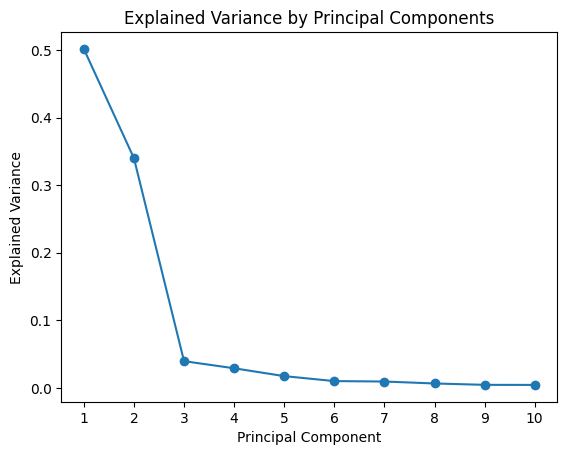

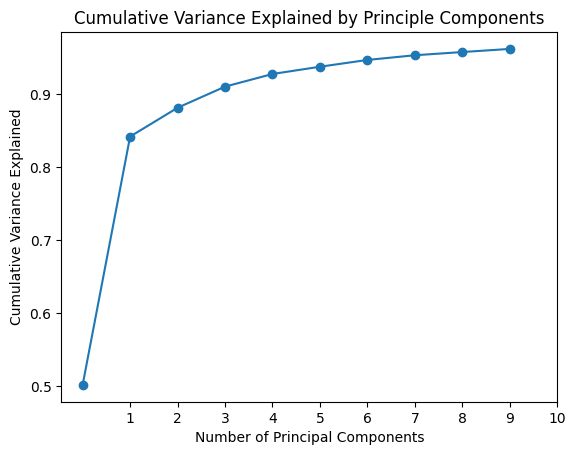

In [20]:
# use elbow method on variance explained to select optimal number of principal components
explained_variance = pca.explained_variance_ratio_

# plot explained variance against principal component
plt.plot(range(1, len(explained_variance) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

# also check cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Variance Explained by Principle Components')
plt.xlabel('Number of Principal Components')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.ylabel('Cumulative Variance Explained') ;

In [21]:
# optimal pcs
pca2 = PCA(n_components=2)
PCAreduced_data = pca2.fit_transform(scaled_data)

In [22]:
# Get the loadings (coefficients) for the first principal components
loadings = pca2.components_[:2]

# Get the absolute values of the loadings
# abs_loadings = np.abs(loadings)

# Find the indices of top features for each principal component in descending order
top_features_indices = np.argsort(loadings, axis=1)[:, ::-1]

# list genes
genes = list(scaled_data.columns)

# number of pcs
num_pcs = top_features_indices.shape[0]

# for each pc find the top contributing elements
for pc in range(num_pcs):

    # top features in each pc
    idx = top_features_indices[pc]
    first = idx[0]
    last = idx[-1]

    # list out name of pcs
    print(f"Top positive feature for Principal Component {pc + 1}: {genes[first]}")
    print(f"Top negative feature for Principal Component {pc + 1}: {genes[last]}")


Top positive feature for Principal Component 1: VGF
Top negative feature for Principal Component 1: TYRP1
Top positive feature for Principal Component 2: TYRP1
Top negative feature for Principal Component 2: TXNIP


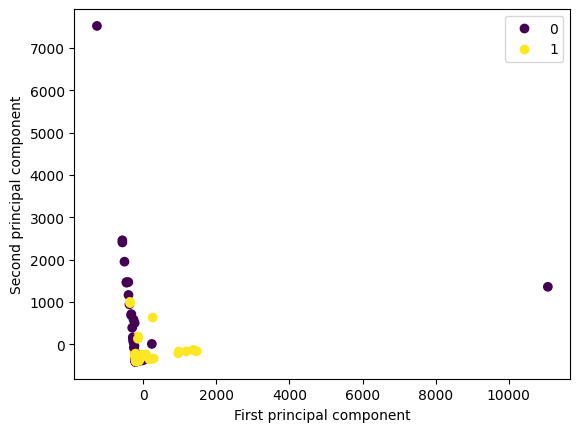

In [25]:
fig = plt.scatter(PCAreduced_data[:, 0], PCAreduced_data[:, 1], c=labels['Response'])

# Set labels for x and y axes
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend(handles=fig.legend_elements()[0], labels=list(set(labels['Response'])))
plt.show()


In [32]:
# Train a logistic regression model using the top PCs before optimizing hyperparameters
X_train, X_test, y_train, y_test = train_test_split(PCAreduced_data, labels['Response'], test_size = 0.3, random_state=1210)
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_train)
training_accuracy = accuracy_score(y_pred, y_train)
y_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test)
print("Training accuracy before hyperparameter optimization:", training_accuracy)
print("Test set accuracy before hyperparameter optimization:", test_accuracy)

Training accuracy before hyperparameter optimization: 0.6419753086419753
Test set accuracy before hyperparameter optimization: 0.7428571428571429


In [33]:
# cv of PCA (number of PCs) and L1 logistic regression

pipeline = Pipeline([
    ('pca', PCA()),
    ('clf', LogisticRegression(penalty = 'l1'))

])

hyperparameters = {
    'pca__n_components': list(range(1, 10)),
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [1000]
}

grid_search = GridSearchCV(pipeline, hyperparameters,  cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters:", best_params)

Best hyperparameters: {'clf__C': 10, 'clf__max_iter': 1000, 'clf__solver': 'liblinear', 'pca__n_components': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
350 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-p

In [34]:
# Train a logistic regression model using the top PCs after optimizing hyperparameters
y_pred = best_model.predict(X_train)
training_accuracy = accuracy_score(y_pred, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_pred, y_test)

print("Training accuracy after hyperparameter optimization:", training_accuracy)
print("Test set accuracy after hyperparameter optimization:", test_accuracy)

Training accuracy after hyperparameter optimization: 0.6419753086419753
Test set accuracy after hyperparameter optimization: 0.7428571428571429


In [30]:
# export cluster assignments
predictions = best_model.predict(PCAreduced_data)
clusters_pca = pd.concat([pd.DataFrame(labels), pd.DataFrame(predictions, columns = ['cluster'])], axis = 1)
clusters_pca.to_csv('/clusters_pca.csv')